另外一个 LightGCN MovieLens 的 [notebook] (http://localhost:8888/notebooks/PyTorch_RecSys/LightGCN_for_Movie_Rec%20/LightGCN%20for%20Movie%20Recommendation%20by%20Quinn%20Wang.ipynb) 看的实在是太 struggle 了，而且 recall 非常低，肯定是哪里没写对，我一步步 debug ，不如先看一下这个，我突然找到这个也是 Stanford 224W 的，也是 LightGCN， 也是 Movie Lens

- Blog: https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e
- Code: https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing


突然发现这个内容好像似曾相识啊.. 难道我很早以前就看过?

这个 Notebook 是尝试不用 SparseTensor 来写，因为我没有 GPU
- 参考这里的 https://colab.research.google.com/drive/1VQTBxJuty7aLMepjEYE-d7E9kjo51CA1?usp=sharing#scrollTo=-aTMoHisNIh_  LightGCNConv 的部分写法
- original blog: https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377


Result: 
- training: [train_loss: -1530.55237, val_loss: -1171.65869, val_recall@20: 0.21551, val_precision@20: 0.03761, val_ndcg@20: 0.13316]
- [test_loss: -1166.86792, test_recall@20: 0.21978, test_precision@20: 0.03853, test_ndcg@20: 0.13844

效果不错呀

# Imports

In [1]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Load Dataset

In [2]:
# download the dataset
# Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [3]:
# load user and movie nodes
# def load_node_csv(path, index_col):
#     """Loads csv containing node information

#     Args:
#         path (str): path to csv file
#         index_col (str): column name of index column

#     Returns:
#         dict: mapping of csv row to node id
#     """
#     df = pd.read_csv(path, index_col=index_col)
#     mapping = {index: i for i, index in enumerate(df.index.unique())}
#     return mapping

# # 诶这两只是 dictionary? 所以其实跟另一个一样，也是 label encoder 的 manual 写法, 
# user_mapping = load_node_csv(rating_path, index_col='userId') # 这里其实直接传 user_path 其实也行
# movie_mapping = load_node_csv(movie_path, index_col='movieId')


# new way

rating_df = pd.read_csv(rating_path)

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [4]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [5]:
# ------ new -----
# load edges between users and movies
def load_edge_csv(df, 
                  src_index_col, 
                  dst_index_col, 
                  link_index_col, 
                  rating_threshold=3):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    
    edge_index = None
    src = [user_id for user_id in  df['userId']]
    
    num_users = len(df['userId'].unique())
    
    # dst 全部 offset by num_users ，因为是 bipartite graph
#     dst = [(movie_id + num_users) for movie_id in df['movieId']]
    # 改回来
    dst = [(movie_id) for movie_id in df['movieId']]

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    # 这里就是把 上面的 src list (user), dst list (item), edge_attr(boolean), 转成 PyG Edge_index 需要的COO 格式
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index

# 这里 print 出来之后，直接就是 COO 格式了!! 即 2 x num_edge_pair. 就是 pyG tutorial 的第一个tutorial 里面的


In [6]:

edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=1,
)

In [7]:
# 都转成 tensor
edge_index = torch.LongTensor(edge_index) # 如果不是 SparseTensor， 那么.propagate 需要 longTensor
# bidirectiona_edge_index = torch.tensor(bidirectiona_edge_index)

In [8]:
# 牛逼，这里 print 出来之后，直接就是 COO 格式了!!
# Q: 但是这里感觉有个问题... 这里是 bipartite graph， 我如果直接 COO 这样写， user_id = 0 盒 item_id = 0 会被当成同一个 node.?
# ?? 有没有可能哪里暗示了是 bipartite graph

# 还真是不太对， 怎么会出现 这么大的数
# 这下就对了，我上面弄的没有用 encoded 的 rating_df 穿进去，而是重新读了，那么不是 label encoded 确实是会有问题

print(edge_index)

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])


In [9]:
# split the edges of the graph using a 80/10/10 train/validation/test split
# num_users, num_movies = len(user_mapping), len(movie_mapping)

num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [10]:
def convert_bipartate_edge_index_to_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [11]:
print(edge_index)
print(edge_index.size())
# bipartate_edge_index = convert_bipartate_edge_index_to_edge_index(edge_index)
# print(bipartate_edge_index.size())


tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])


In [12]:
# 这里其实是算的  4 分以上的 interaction
num_interactions = edge_index.shape[1]
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")


num_users 610, num_movies 9724, num_interactions 99466


In [13]:
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

# 诶，原来 validation 是从test set 里面再 split 出来，我一直以为是从给training set
val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

In [14]:
# 这里就是拿到 edge pair index 其实还是 tensor, 
# 所以这里其实就是 把 edge_index 拆成 training set, validation set, test set... 
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [15]:
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(edge_index[0]).size())
print(torch.unique(edge_index[1]).size())
print(train_edge_index.min())
print(train_edge_index.max())
print(edge_index.max())

train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([9628])
tensor(0)
tensor(9723)
tensor(9723)


In [16]:
# 这里得把上面的转成 bipartite
train_edge_index = convert_bipartate_edge_index_to_edge_index(train_edge_index)
val_edge_index = convert_bipartate_edge_index_to_edge_index(val_edge_index)
test_edge_index = convert_bipartate_edge_index_to_edge_index(test_edge_index)

In [17]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])


In [18]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
# 这里为啥？？"In PyG >= 1.6.0, we officially introduce better support for sparse-matrix multiplication GNNs, resulting in a lower memory footprint and a faster execution time"


# 这里崩了?? 这是为啥？？
# 难道是因为这里其实才是对 bipartate graph 的处理？？ 你看 sparse size 是 num_users + num_movies
# 我如果不用呢？

# 这里为啥过不来???
# 是不是不能用 num_users + num_movies 了，因为我已经处理了 bipartite?? 那应该用啥？
# 难道是 row, col 的 index 超出范围了? (num_users + num_movies) = 10334
# Solved: load_edge_csv 有个小 bug， 没有用 label encoded 的 id, 
# train_sparse_edge_index = SparseTensor(row=train_edge_index[0], 
#                                        col=train_edge_index[1], 
#                                        sparse_sizes=((num_users + num_movies), num_users + num_movies))

# val_sparse_edge_index = SparseTensor(row=val_edge_index[0], 
#                                      col=val_edge_index[1], 
#                                      sparse_sizes=(num_users + num_movies, num_users + num_movies))

# test_sparse_edge_index = SparseTensor(row=test_edge_index[0], 
#                                       col=test_edge_index[1], 
#                                       sparse_sizes=(num_users + num_movies, num_users + num_movies))




In [19]:
# print(train_sparse_edge_index.to_torch_sparse_coo_tensor())
# print(train_sparse_edge_index)

In [20]:
# function which random samples a mini-batch of positive and negative samples
# 因为我 edge_index 改成 bidirection 了，我这里其实是要改一下的，因为不再是 src 全是 user, dst 全是 target 了
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    # structured_negative_sampling(...) 这个是一个 pyG library
    # Samples a negative edge :obj:`(i,k)` for every positive edge
    # :obj:`(i,j)` in the graph given by :attr:`edge_index`, and returns it as a
    # tuple of the form :obj:`(i,j,k)`.
    # 看上面的 print, 其实还是 coo 类似的格式
    edges = structured_negative_sampling(edge_index)
    
    # 变成 3 x num_edge_pair  的格式， 然后 row0, row1 是 positive, row0, row2 是 negative?
    # Q: 他这里怎么知道 negative 是从 movie list 里面拿? 我估计 structured_negative_sampling 知道从 
    # dest list 里面选，而不是从 src list 里面选
    edges = torch.stack(edges, dim=0)
    
    # Return a k sized list of population elements chosen with replacement.
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    
    batch = edges[:, indices]
    
    # 上面 batch print 出来知道长啥样，这个就挺 straightforward 
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix



__TODO__: 上面这个有点没看懂，得查一下
- https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix
- [拉普拉斯矩阵(Laplacian Matrix) 及半正定性证明](https://www.cnblogs.com/shiyublog/p/9785342.html)
- 我大概知道了，按陈学长跟我讲的去复习一下，然后先把 RMSE 的方法弄一下，然后回头再看下面这几个资料
    - [SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907.pdf%EF%BC%89)
    - [LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation](https://arxiv.org/pdf/2002.02126.pdf) 尤其 formula 7
    - https://en.m.wikipedia.org/wiki/Laplacian_matrix
    - PyG GCN Norm Doc [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.GCNNorm), [source code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/transforms/gcn_norm.html#GCNNorm)
    - PyG 的 LG_CONV (单层的) Light GCN [link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/lg_conv.html#LGConv)
    - PyG 的Light GCN 整个 network [link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/lightgcn.html)
    - Normalized Adjacency and Laplacian Matrices Cornell Slides [link](https://people.orie.cornell.edu/dpw/orie6334/Fall2016/lecture7.pdf)
    - [SO]Interpretation of Symmetric Normalised Graph Adjacency Matrix [link](https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix)
- 这个有几个问题，一个是 bipartate graph 的 Adj Matrix 他是不是没有设置好，
- 


In [21]:
# # defines LightGCN model (with SparseTensor Optimization)
# class LightGCN(MessagePassing):
#     """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
#     """

#     def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
#         """Initializes LightGCN Model

#         Args:
#             num_users (int): Number of users
#             num_items (int): Number of items
#             embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
#             K (int, optional): Number of message passing layers. Defaults to 3.
#             add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
#         """
#         super().__init__()
#         self.num_users = num_users
#         self.num_items = num_items
#         self.embedding_dim = embedding_dim
#         self.K = K
#         self.add_self_loops = add_self_loops

#         # 这边 embedding 就参考 我的 Basic NCF 的那个 notebook 
#         self.users_emb = nn.Embedding(num_embeddings=self.num_users, 
#                                       embedding_dim=self.embedding_dim) # e_u^0
        
#         self.items_emb = nn.Embedding(num_embeddings=self.num_items, 
#                                       embedding_dim=self.embedding_dim) # e_i^0

#         # 这啥？哦就是 上面两 embedding 的 initialization 方法， 当然，也可以把 feature 放进来作为初始 embeding
#         # "Fills the input Tensor with values drawn from the normal distribution"
#         nn.init.normal_(self.users_emb.weight, std=0.1)
#         nn.init.normal_(self.items_emb.weight, std=0.1)

#     def forward(self, edge_index: SparseTensor):
#         """Forward propagation of LightGCN Model.

#         Args:
#             edge_index (SparseTensor): adjacency matrix

#         Returns:
#             tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
#         """
#         # compute \tilde{A}: symmetrically normalized adjacency matrix
#         # TODO: 这个是啥骚操作? 这边得仔细看一下!!! (上面我有做笔记了.)
#         # 这里 print 出来之后，长度可能跟 edge_index 不一样了，因为有加 selfloop， 到时候可以验证一下
#         edge_index_norm = gcn_norm(edge_index=edge_index, 
#                                    add_self_loops=self.add_self_loops)

#         # 直接 user, item embedding concat 然后套一曾，然后 rename??
#         emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
#         # 哦，不是套一层，而是因为 lightGCN 最后从 多跟 emb_k 算出 emb 是直接加， 所以这里建一个 list
#         # 你看后面 propagate 多层 LightGCN layer 的时候，一方面 propagate， 一方面每一层我都 append 到 embs 这个list
#         embs = [emb_0]
#         emb_k = emb_0

#         # multi-scale diffusion
#         # 这个跟你用几层 LightGCn 有关，一层，你都 
#         # 注意这里，咱们是用 emb_k 作为 node  的 feature 了!!!  
#         # TODO: 可以思考一下这里要加真正的 node feature 怎么加？直接 concat? 补进去?
#         for i in range(self.K):
#             # 他着跟这里讲的不太一样呀？“For bipartite graphs with two independent sets of nodes and indices, and each set holding its own information, this split can be marked by passing the information as a tuple, e.g. x=(x_N, x_M)”
#             # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html?highlight=bipartate#the-messagepassing-base-class
#             emb_k = self.propagate(edge_index_norm, x=emb_k)
#             embs.append(emb_k)

#         # 这个到时候可以看一下 dim=1 的 stack 长啥样
#         # 可以参考这个 https://www.geeksforgeeks.org/python-pytorch-stack-method/
#         # 就是比如 [[1,2,3,4], [5,6,7,8]]
#         # stack 完变成[ [1,5], [2,6],[3, 7], [4, 8] ]
#         embs = torch.stack(embs, dim=1)
        
#         # 然后这边就是把上面 stack 完的求均值
#         # Q: ?? lightGCN 是求均值吗? 不是应该是 weighted sum?? 不过 sum or avg 应该都不影响结果
#         # A: 看 paper 里面， 公式里的 a 其实是 1/(K+1) 那本质上就是 avg 了
#         emb_final = torch.mean(embs, dim=1) # E^K

#         # 这个比较 straightforward, 我们上面 embedding 不是用 concat 把 user_emb 和 item_emb 给
#         # horizontal 连起来吗， 这里跑完 LightGCN layer 之后，我们就可以在 split 拆开左右两边，拿到各种的 embedding
#         # 那其实跟 NCF 还是蛮像的.
#         users_emb_final, items_emb_final = torch.split(emb_final, 
#                                                        [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

#         # returns e_u^K, e_u^0, e_i^K, e_i^0
#         return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

#     # 是不是下面这两个我没有看懂？？
#     def message(self, x_j: Tensor) -> Tensor:
#         return x_j

#     # 是不是下面这个我没有看懂？？
#     # 这里也解释的不是很清： https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
#     def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
#         # computes \tilde{A} @ x
#         # adj_t 是 adj transpose
#         # matmul 是 dot product
#         return matmul(adj_t, x)

# # 试一下只用2层
# layers = 3    
# model = LightGCN(num_users=num_users, 
#                  num_items=num_movies, 
#                  K=layers)

In [22]:
# defines LightGCN model (without SparseTensor Optimization)
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # 这边 embedding 就参考 我的 Basic NCF 的那个 notebook 
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, 
                                      embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, 
                                      embedding_dim=self.embedding_dim) # e_i^0

        # 这啥？哦就是 上面两 embedding 的 initialization 方法， 当然，也可以把 feature 放进来作为初始 embeding
        # "Fills the input Tensor with values drawn from the normal distribution"
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        # TODO: 这个是啥骚操作? 这边得仔细看一下!!! (上面我有做笔记了.)
        # 这里 print 出来之后，长度可能跟 edge_index 不一样了，因为有加 selfloop， 到时候可以验证一下
        # 这个是返回  tuple of size 2, pos0 是 原版 edge_index, pos1 是算好的 norm, 1 x num_of_total_nodes
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # 直接 user, item embedding concat 然后套一曾，然后 rename??
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        # 哦，不是套一层，而是因为 lightGCN 最后从 多跟 emb_k 算出 emb 是直接加， 所以这里建一个 list
        # 你看后面 propagate 多层 LightGCN layer 的时候，一方面 propagate， 一方面每一层我都 append 到 embs 这个list
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        # 这个跟你用几层 LightGCn 有关，一层，你都 
        # 注意这里，咱们是用 emb_k 作为 node  的 feature 了!!!  
        # TODO: 可以思考一下这里要加真正的 node feature 怎么加？直接 concat? 补进去?
        for i in range(self.K):
            # 他着跟这里讲的不太一样呀？“For bipartite graphs with two independent sets of nodes and indices, and each set holding its own information, this split can be marked by passing the information as a tuple, e.g. x=(x_N, x_M)”
            # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html?highlight=bipartate#the-messagepassing-base-class
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        # 这个到时候可以看一下 dim=1 的 stack 长啥样
        # 可以参考这个 https://www.geeksforgeeks.org/python-pytorch-stack-method/
        # 就是比如 [[1,2,3,4], [5,6,7,8]]
        # stack 完变成[ [1,5], [2,6],[3, 7], [4, 8] ]
        embs = torch.stack(embs, dim=1)
        
        # 然后这边就是把上面 stack 完的求均值
        # Q: ?? lightGCN 是求均值吗? 不是应该是 weighted sum?? 不过 sum or avg 应该都不影响结果
        # A: 看 paper 里面， 公式里的 a 其实是 1/(K+1) 那本质上就是 avg 了
        emb_final = torch.mean(embs, dim=1) # E^K

        # 这个比较 straightforward, 我们上面 embedding 不是用 concat 把 user_emb 和 item_emb 给
        # horizontal 连起来吗， 这里跑完 LightGCN layer 之后，我们就可以在 split 拆开左右两边，拿到各种的 embedding
        # 那其实跟 NCF 还是蛮像的.
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

# 试一下只用2层
layers = 3    
model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [23]:
# 看公式，还真是需要 layer 0 embedding 作为一个 bias term.. 有意思了..
def bpr_loss(users_emb_final, 
             users_emb_0, 
             pos_items_emb_final, 
             pos_items_emb_0, 
             neg_items_emb_final, 
             neg_items_emb_0, 
             lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [24]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges 也就是 COO 格式

    Returns:
        dict: dictionary of positive items for each user
    """
    
    # key: user_id, val: item_id list
    user_pos_items = {}
    # 在 COO 格式 edge index 的第二个 dim 来 iterate， 也就是 edge pair 一个个过
    for i in range(edge_index.shape[1]):
        # 这里就是拿到一个个 user, item edge pair
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        user_pos_items[user].append(item)
        
    # 所以这里只要是 edge_index 里面有连接，就是 positive sample??
    return user_pos_items

In [25]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [26]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [27]:
# wrapper function to get evaluation metrics
# 这一段好好看一下?? 我好奇为什么 BPR loss 往下走的，暗示 recall 没有.

# 这边我看上面是直接拿 [train_edge_index] 作为 exclude_edge_index, 因为你是做 evaluation
# 他为什么要 exclude?? 哦，因为我 validation 的时候，我的 relevant item 要只看 validation set 里面的? 
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    # Matrix product of two tensors. 
    # 这么神奇？哦，不过也 make sense  (num_users x 64) dot_product (num_item x 64).T 那么每个 entry 其实就是pred rating
    rating = torch.matmul(user_embedding, item_embedding.T)
    
    # 这里把 rating 从 interaction mat 转成 bipartite adj mat 为了后面好算？
    rating_transpose = torch.transpose(rating, 0, 1)
    rating_adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    rating_adj_mat[: num_users, num_users :] = rating.clone()
    rating_adj_mat[num_users :, : num_users] = rating_transpose.clone()

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        # 这里应该只是转成  user -> positive item list
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            # 这个是为啥？为啥还 * len(item)， 为了平衡吗？非得把 exclude_user 的长度跟 exclude_item 长度一样
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

            
            
        # set ratings of excluded edges to large negative value
        # 这一步崩的?? 想一想我的 bipartite 的处理，怎么去做这个 encoding 的offset 比较好一点...
        # 不然老是 index 出错， 我这里先笨方法，直接先 减 num_users 了.. TODO: 得想想有没有更 clean 的方法
        # 诶，卧槽，这里忘记改了，这里得拿掉，，我用大 matrix 不需要 offset...
        # exclude_items = [item_id - num_users for item_id in exclude_items]
        
        # 这里就是设成一个非常小的数， 为啥要这个?? 因为下面有个rating
        rating_adj_mat[exclude_users, exclude_items] = -(1 << 10) 

    # get the top k recommended items for each user
    # 其实这里，我应该只需要前 num_user 个？
    _, top_K_items = torch.topk(rating_adj_mat, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    # 得到一个 dict of user -> pos_item list
    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list， 那这不是成了 list of list?
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    # r here is the ground truth?? 也就是 pred_relevant_and_is_actually_relevant item list for each user
    # 这里是 list of list 的格式
    r = []
    for user in users:
        # 拿到每个 user  的 relevant items
        ground_truth_items = test_user_pos_items[user.item()]
        # 这啥？哦, python 的 lambda 写法，其实是对 top_K_items[user]， 也就是 recommended top k
        # 看有多少是 actually relevant ， 这样 我的  recall 的分子 就拿到了
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
        
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [28]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)
    
    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    
    # bipartite graph 的处理
    users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)
    users_items_emb_0 = torch.cat([users_emb_0, items_emb_0], dim=0)
    
    users_emb_final, users_emb_0 = users_items_emb_final[user_indices], users_items_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = users_items_emb_final[pos_item_indices], users_items_emb_0[pos_item_indices]
    
    neg_items_emb_final, neg_items_emb_0 = users_items_emb_final[neg_item_indices], users_items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, 
                    users_emb_0, 
                    pos_items_emb_final, 
                    pos_items_emb_0,
                    neg_items_emb_final, 
                    neg_items_emb_0, 
                    lambda_val).item()

    #... 这里崩了... 也真是无语.... 改个 bipartite 这么难... 
    recall, precision, ndcg = get_metrics(model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

_---------- maual explore start--------------_

In [35]:
print(edge_index.long())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])


In [70]:
print(edge_index.type())
print(train_edge_index)
print(train_edge_index.type())
print(train_edge_index.size())

torch.LongTensor
tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.LongTensor
torch.Size([2, 159144])


In [71]:
edge_index_norm = gcn_norm(edge_index=train_edge_index, 
                                   add_self_loops=False)

In [87]:
# print(edge_index_norm.size())
# print(edge_index_norm.type())
print(edge_index_norm)

# 估计因为不能这么弄, 他这个格式不一样
print(edge_index.size())

print(num_users)

print(edge_index.dtype)

print(edge_index_norm[1])

(tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]]), tensor([0.0057, 0.0084, 0.0059,  ..., 0.0976, 0.0976, 0.0884]))
torch.Size([2, 99466])
610
torch.int64
tensor([0.0057, 0.0084, 0.0059,  ..., 0.0976, 0.0976, 0.0884])


In [85]:
# 诶，他这个是拿 embedding 来算 degree? 没必要把? edge_index  不能算? 不需要啦
def get_norm(edge_index):
    from_, to_ = edge_index
    deg = degree(to_, (num_users + num_movies), dtype=edge_index.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]
    return norm

In [86]:
# 这个算出来， 跟 import 的 gcn_norm 的返回的 print(edge_index_norm[1]) 一样的
norm = get_norm(train_edge_index)
print(norm)

tensor([0.0057, 0.0084, 0.0059,  ..., 0.0976, 0.0976, 0.0884])


_---------- maual explore stop--------------_

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [30]:
# define contants
ITERATIONS = 10000
EPOCHS = 10
# ITERATIONS = 500
BATCH_SIZE = 1024
# 我觉得下面写的有点问题，不然我每个 batch 都是全部数据吧?
# BATCH_SIZE = len(train_edge_index[0])

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
# K = 10
# K = 10 是不是太多了?? 这个会导致 layer oversmooth? 不过好像没有用这个 K? 哦，不是，这个是 eval metric的 K 
K = 20
LAMBDA = 1e-6
# LAMBDA = 1/2

In [31]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [32]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
# train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
# val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [33]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation
    # todo: 估计是这里要给他转成 bidirectional 的，这样信息才完整
#     bidirectional_train_edge_index = to_bidirectional(train_edge_index)
    
#     bidirectional_train_sparse_edge_index = SparseTensor(
#                                        row=bidirectional_train_edge_index[0], 
#                                        col=bidirectional_train_edge_index[1], 
#                                        sparse_sizes=((num_users + num_movies), num_users + num_movies))

    
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_edge_index)

    # mini batching for eval and calculate loss 
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    # print(f"user_indices {user_indices}, pos_item_indices {pos_item_indices}, neg_item_indices {neg_item_indices}")
    
    # 全部转成 to(device) 的格式
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
    
    # concat 一下，不然我的 bipartite 处理之后, item 的 range 已经变了
    users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)
    users_items_emb_0 = torch.cat([users_emb_0, items_emb_0], dim=0)
    
    
    # 拿到第一层，和最后一层的 user embedding?
    users_emb_final, users_emb_0 = users_items_emb_final[user_indices], users_items_emb_0[user_indices]

    # 拿到第一层，和最后一层的 positive item embedding?
    # TODO; 这里要记得 干脆 user 和 item embedding concat 一下，不然总是出街
    pos_items_emb_final, pos_items_emb_0 = users_items_emb_final[pos_item_indices], users_items_emb_0[pos_item_indices]

    # 拿到第一层，和最后一层的 negative item embedding?    
    neg_items_emb_final, neg_items_emb_0 = users_items_emb_final[neg_item_indices], users_items_emb_0[neg_item_indices]

    # loss computation
    # TODO；  这边看一下能不能 incorporate RMSE loss 这样也许 recall 就会提高不少
    # 当然，要思考一下，他这边怎么去算 RMSE loss? 不过应该是有 edge index 本质上是edge pair 应该是可以算吧?
    # Question: BPR loss 需要最后一层和第一层吗？？
    train_loss = bpr_loss(users_emb_final, 
                          users_emb_0, 
                          pos_items_emb_final,
                          pos_items_emb_0, 
                          neg_items_emb_final, 
                          neg_items_emb_0, 
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # 这里就是过 validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        

        # 为啥这里需要 val_sparse_edge_index
        val_loss, recall, precision, ndcg = evaluation(model, 
                                                       val_edge_index, 
                                                       val_edge_index, 
                                                       [train_edge_index], 
                                                       K, 
                                                       LAMBDA)
        
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|                                                                                        | 1/10000 [00:05<16:27:38,  5.93s/it]

[Iteration 0/10000] train_loss: -0.69209, val_loss: -0.66326, val_recall@20: 0.02712, val_precision@20: 0.00419, val_ndcg@20: 0.01274


  2%|█▋                                                                                     | 201/10000 [01:45<6:06:55,  2.25s/it]

[Iteration 200/10000] train_loss: -6.54349, val_loss: -5.02385, val_recall@20: 0.0794, val_precision@20: 0.01456, val_ndcg@20: 0.04522


  4%|███▍                                                                                   | 401/10000 [03:28<6:05:24,  2.28s/it]

[Iteration 400/10000] train_loss: -26.14535, val_loss: -20.74295, val_recall@20: 0.09481, val_precision@20: 0.01783, val_ndcg@20: 0.05815


  6%|█████▏                                                                                 | 601/10000 [05:06<5:54:18,  2.26s/it]

[Iteration 600/10000] train_loss: -56.76345, val_loss: -43.9276, val_recall@20: 0.10884, val_precision@20: 0.02148, val_ndcg@20: 0.07147


  8%|██████▉                                                                                | 801/10000 [06:39<5:34:36,  2.18s/it]

[Iteration 800/10000] train_loss: -92.58365, val_loss: -72.58499, val_recall@20: 0.11717, val_precision@20: 0.02321, val_ndcg@20: 0.076


 10%|████████▌                                                                             | 1001/10000 [08:12<4:57:48,  1.99s/it]

[Iteration 1000/10000] train_loss: -134.93996, val_loss: -105.00739, val_recall@20: 0.13733, val_precision@20: 0.02597, val_ndcg@20: 0.08801


 12%|██████████▎                                                                           | 1201/10000 [09:41<4:43:29,  1.93s/it]

[Iteration 1200/10000] train_loss: -182.3392, val_loss: -140.27936, val_recall@20: 0.14761, val_precision@20: 0.02779, val_ndcg@20: 0.09447


 14%|████████████                                                                          | 1401/10000 [11:10<4:39:11,  1.95s/it]

[Iteration 1400/10000] train_loss: -228.33195, val_loss: -178.31656, val_recall@20: 0.16028, val_precision@20: 0.02935, val_ndcg@20: 0.09951


 16%|█████████████▊                                                                        | 1601/10000 [12:39<4:28:40,  1.92s/it]

[Iteration 1600/10000] train_loss: -274.96378, val_loss: -218.40941, val_recall@20: 0.16628, val_precision@20: 0.03065, val_ndcg@20: 0.1025


 18%|███████████████▍                                                                      | 1801/10000 [14:11<6:01:43,  2.65s/it]

[Iteration 1800/10000] train_loss: -333.42004, val_loss: -256.72653, val_recall@20: 0.16783, val_precision@20: 0.03127, val_ndcg@20: 0.10357


 20%|█████████████████▏                                                                    | 2001/10000 [16:02<5:48:25,  2.61s/it]

[Iteration 2000/10000] train_loss: -401.49152, val_loss: -296.64316, val_recall@20: 0.18939, val_precision@20: 0.03375, val_ndcg@20: 0.11223


 22%|██████████████████▉                                                                   | 2201/10000 [18:01<5:28:36,  2.53s/it]

[Iteration 2200/10000] train_loss: -457.39661, val_loss: -337.33359, val_recall@20: 0.1948, val_precision@20: 0.03407, val_ndcg@20: 0.11369


 24%|████████████████████▋                                                                 | 2401/10000 [19:42<4:04:31,  1.93s/it]

[Iteration 2400/10000] train_loss: -452.58487, val_loss: -374.36536, val_recall@20: 0.198, val_precision@20: 0.03461, val_ndcg@20: 0.11681


 26%|██████████████████████▎                                                               | 2601/10000 [21:12<4:06:47,  2.00s/it]

[Iteration 2600/10000] train_loss: -554.84973, val_loss: -414.49774, val_recall@20: 0.19924, val_precision@20: 0.03501, val_ndcg@20: 0.11672


 28%|████████████████████████                                                              | 2801/10000 [22:42<4:03:44,  2.03s/it]

[Iteration 2800/10000] train_loss: -577.86475, val_loss: -453.63278, val_recall@20: 0.20192, val_precision@20: 0.03545, val_ndcg@20: 0.11912


 30%|█████████████████████████▊                                                            | 3001/10000 [24:12<3:52:01,  1.99s/it]

[Iteration 3000/10000] train_loss: -655.05884, val_loss: -491.50644, val_recall@20: 0.20004, val_precision@20: 0.03553, val_ndcg@20: 0.12081


 32%|███████████████████████████▌                                                          | 3201/10000 [25:42<3:47:04,  2.00s/it]

[Iteration 3200/10000] train_loss: -683.01868, val_loss: -524.63269, val_recall@20: 0.20328, val_precision@20: 0.03568, val_ndcg@20: 0.12294


 34%|█████████████████████████████▏                                                        | 3401/10000 [27:12<3:36:33,  1.97s/it]

[Iteration 3400/10000] train_loss: -709.64496, val_loss: -561.19617, val_recall@20: 0.20591, val_precision@20: 0.03595, val_ndcg@20: 0.12404


 36%|██████████████████████████████▉                                                       | 3601/10000 [28:42<3:30:10,  1.97s/it]

[Iteration 3600/10000] train_loss: -770.69617, val_loss: -593.22345, val_recall@20: 0.20946, val_precision@20: 0.0366, val_ndcg@20: 0.12758


 38%|████████████████████████████████▋                                                     | 3801/10000 [30:11<3:18:43,  1.92s/it]

[Iteration 3800/10000] train_loss: -840.37213, val_loss: -625.78949, val_recall@20: 0.20886, val_precision@20: 0.03676, val_ndcg@20: 0.12659


 40%|██████████████████████████████████▍                                                   | 4001/10000 [31:41<3:18:29,  1.99s/it]

[Iteration 4000/10000] train_loss: -935.68195, val_loss: -657.03394, val_recall@20: 0.21079, val_precision@20: 0.03679, val_ndcg@20: 0.12747


 42%|████████████████████████████████████▏                                                 | 4201/10000 [33:11<3:08:15,  1.95s/it]

[Iteration 4200/10000] train_loss: -880.8844, val_loss: -692.07233, val_recall@20: 0.21032, val_precision@20: 0.0369, val_ndcg@20: 0.12824


 44%|█████████████████████████████████████▊                                                | 4401/10000 [34:41<3:05:16,  1.99s/it]

[Iteration 4400/10000] train_loss: -933.46802, val_loss: -721.06012, val_recall@20: 0.21082, val_precision@20: 0.03705, val_ndcg@20: 0.12884


 46%|███████████████████████████████████████▌                                              | 4601/10000 [36:11<2:59:36,  2.00s/it]

[Iteration 4600/10000] train_loss: -945.86304, val_loss: -746.67285, val_recall@20: 0.21204, val_precision@20: 0.03719, val_ndcg@20: 0.12927


 48%|█████████████████████████████████████████▎                                            | 4801/10000 [37:41<2:49:17,  1.95s/it]

[Iteration 4800/10000] train_loss: -969.49072, val_loss: -772.54907, val_recall@20: 0.21034, val_precision@20: 0.03708, val_ndcg@20: 0.12879


 50%|███████████████████████████████████████████                                           | 5001/10000 [39:10<2:40:24,  1.93s/it]

[Iteration 5000/10000] train_loss: -993.11053, val_loss: -800.82843, val_recall@20: 0.21317, val_precision@20: 0.03741, val_ndcg@20: 0.12996


 52%|████████████████████████████████████████████▋                                         | 5201/10000 [40:39<2:38:03,  1.98s/it]

[Iteration 5200/10000] train_loss: -1077.74548, val_loss: -827.60547, val_recall@20: 0.21209, val_precision@20: 0.03718, val_ndcg@20: 0.13057


 54%|██████████████████████████████████████████████▍                                       | 5401/10000 [42:08<2:29:30,  1.95s/it]

[Iteration 5400/10000] train_loss: -1078.01892, val_loss: -850.48157, val_recall@20: 0.21204, val_precision@20: 0.03737, val_ndcg@20: 0.13075


 56%|████████████████████████████████████████████████▏                                     | 5601/10000 [43:37<2:24:02,  1.96s/it]

[Iteration 5600/10000] train_loss: -1108.09998, val_loss: -870.46741, val_recall@20: 0.21292, val_precision@20: 0.03731, val_ndcg@20: 0.13072


 58%|█████████████████████████████████████████████████▉                                    | 5801/10000 [45:07<2:13:38,  1.91s/it]

[Iteration 5800/10000] train_loss: -1205.43408, val_loss: -894.19806, val_recall@20: 0.21193, val_precision@20: 0.03726, val_ndcg@20: 0.13053


 60%|███████████████████████████████████████████████████▌                                  | 6001/10000 [46:38<2:09:07,  1.94s/it]

[Iteration 6000/10000] train_loss: -1156.79431, val_loss: -912.33191, val_recall@20: 0.21297, val_precision@20: 0.03741, val_ndcg@20: 0.13087


 62%|█████████████████████████████████████████████████████▎                                | 6201/10000 [48:07<2:07:40,  2.02s/it]

[Iteration 6200/10000] train_loss: -1218.30725, val_loss: -934.52173, val_recall@20: 0.21231, val_precision@20: 0.03721, val_ndcg@20: 0.13129


 64%|███████████████████████████████████████████████████████                               | 6401/10000 [49:36<2:00:47,  2.01s/it]

[Iteration 6400/10000] train_loss: -1287.18921, val_loss: -953.46069, val_recall@20: 0.21273, val_precision@20: 0.03733, val_ndcg@20: 0.13178


 66%|████████████████████████████████████████████████████████▊                             | 6601/10000 [51:05<1:48:48,  1.92s/it]

[Iteration 6600/10000] train_loss: -1315.4928, val_loss: -970.90613, val_recall@20: 0.21353, val_precision@20: 0.03741, val_ndcg@20: 0.13171


 68%|██████████████████████████████████████████████████████████▍                           | 6801/10000 [52:46<2:17:48,  2.58s/it]

[Iteration 6800/10000] train_loss: -1217.66772, val_loss: -986.20679, val_recall@20: 0.21658, val_precision@20: 0.03759, val_ndcg@20: 0.13265


 70%|████████████████████████████████████████████████████████████▏                         | 7001/10000 [54:34<1:54:00,  2.28s/it]

[Iteration 7000/10000] train_loss: -1270.59619, val_loss: -1001.68701, val_recall@20: 0.21573, val_precision@20: 0.03758, val_ndcg@20: 0.1324


 72%|█████████████████████████████████████████████████████████████▉                        | 7201/10000 [56:16<1:39:43,  2.14s/it]

[Iteration 7200/10000] train_loss: -1376.38965, val_loss: -1021.33923, val_recall@20: 0.21555, val_precision@20: 0.03754, val_ndcg@20: 0.13252


 74%|███████████████████████████████████████████████████████████████▋                      | 7401/10000 [58:02<2:05:23,  2.89s/it]

[Iteration 7400/10000] train_loss: -1347.19934, val_loss: -1038.31726, val_recall@20: 0.21561, val_precision@20: 0.03761, val_ndcg@20: 0.13294


 76%|█████████████████████████████████████████████████████████████████▎                    | 7601/10000 [59:36<1:18:33,  1.96s/it]

[Iteration 7600/10000] train_loss: -1339.99805, val_loss: -1053.19263, val_recall@20: 0.21515, val_precision@20: 0.03745, val_ndcg@20: 0.13231


 78%|█████████████████████████████████████████████████████████████████▌                  | 7801/10000 [1:01:08<1:17:45,  2.12s/it]

[Iteration 7800/10000] train_loss: -1341.4873, val_loss: -1070.44177, val_recall@20: 0.21555, val_precision@20: 0.03755, val_ndcg@20: 0.13264


 80%|███████████████████████████████████████████████████████████████████▏                | 8001/10000 [1:02:44<1:09:19,  2.08s/it]

[Iteration 8000/10000] train_loss: -1319.46667, val_loss: -1077.60828, val_recall@20: 0.21512, val_precision@20: 0.03759, val_ndcg@20: 0.13285


 82%|██████████████████████████████████████████████████████████████████████▌               | 8201/10000 [1:04:18<58:19,  1.95s/it]

[Iteration 8200/10000] train_loss: -1397.19678, val_loss: -1091.00171, val_recall@20: 0.21564, val_precision@20: 0.03767, val_ndcg@20: 0.13313


 84%|████████████████████████████████████████████████████████████████████████▏             | 8401/10000 [1:05:52<52:56,  1.99s/it]

[Iteration 8400/10000] train_loss: -1386.97766, val_loss: -1100.32947, val_recall@20: 0.21516, val_precision@20: 0.03766, val_ndcg@20: 0.13311


 86%|█████████████████████████████████████████████████████████████████████████▉            | 8601/10000 [1:07:25<47:10,  2.02s/it]

[Iteration 8600/10000] train_loss: -1469.28088, val_loss: -1111.79431, val_recall@20: 0.21537, val_precision@20: 0.03768, val_ndcg@20: 0.13313


 88%|███████████████████████████████████████████████████████████████████████████▋          | 8801/10000 [1:09:05<42:54,  2.15s/it]

[Iteration 8800/10000] train_loss: -1471.72412, val_loss: -1119.04016, val_recall@20: 0.21578, val_precision@20: 0.03767, val_ndcg@20: 0.13313


 90%|█████████████████████████████████████████████████████████████████████████████▍        | 9001/10000 [1:10:47<39:08,  2.35s/it]

[Iteration 9000/10000] train_loss: -1478.78552, val_loss: -1132.71924, val_recall@20: 0.21595, val_precision@20: 0.0377, val_ndcg@20: 0.13327


 92%|███████████████████████████████████████████████████████████████████████████████▏      | 9201/10000 [1:12:25<29:39,  2.23s/it]

[Iteration 9200/10000] train_loss: -1415.28479, val_loss: -1141.14136, val_recall@20: 0.21567, val_precision@20: 0.03766, val_ndcg@20: 0.13313


 94%|████████████████████████████████████████████████████████████████████████████████▊     | 9401/10000 [1:14:06<22:26,  2.25s/it]

[Iteration 9400/10000] train_loss: -1492.05872, val_loss: -1152.20618, val_recall@20: 0.21553, val_precision@20: 0.03768, val_ndcg@20: 0.13317


 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 9601/10000 [1:15:43<14:45,  2.22s/it]

[Iteration 9600/10000] train_loss: -1406.0127, val_loss: -1160.36646, val_recall@20: 0.2158, val_precision@20: 0.03767, val_ndcg@20: 0.13325


 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 9801/10000 [1:17:21<07:06,  2.14s/it]

[Iteration 9800/10000] train_loss: -1530.55237, val_loss: -1171.65869, val_recall@20: 0.21551, val_precision@20: 0.03761, val_ndcg@20: 0.13316


100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:18:53<00:00,  2.11it/s]


# Plot

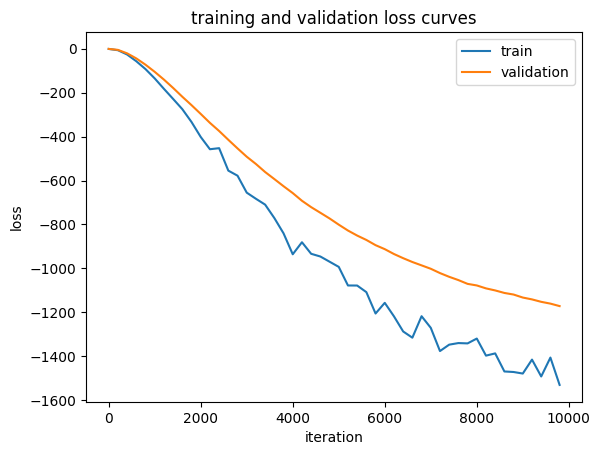

In [34]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

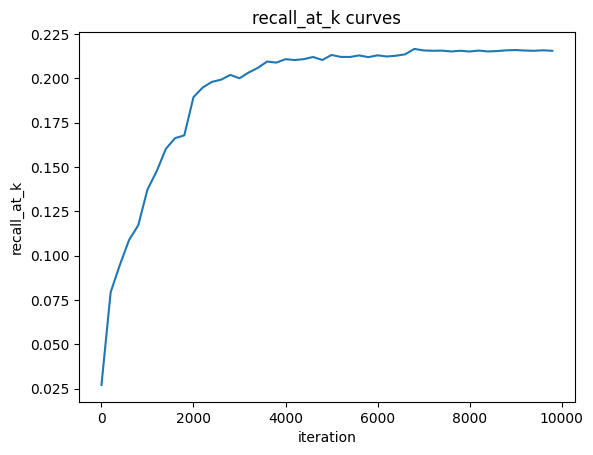

In [35]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [38]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
# test_sparse_edge_index = test_sparse_edge_index.to(device)

# bidirectional_test_edge_index = to_bidirectional(test_edge_index)
# bidirectional_test_sparse_edge_index = SparseTensor(
#                                row=bidirectional_test_edge_index[0], 
#                                col=bidirectional_test_edge_index[1], 
#                                sparse_sizes=((num_users + num_movies), num_users + num_movies))



test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1166.86792, test_recall@20: 0.21978, test_precision@20: 0.03853, test_ndcg@20: 0.13844


发现上面跑出来 效果也一般般
我把原始代码的output 记录一下
- [test_loss: -51.5177, test_recall@10: 0.08269, test_precision@10: 0.05815, test_ndcg@10: 0.09033

卧槽，改了半天 bipartite，改了个寂寞？ (不过我的 iter 用的 500 而不是 10000 好吧，再试一下)
（好像还是不太行，不然我把 bidirectional 拿掉？没有差，好像还是挺差.. 这个真多要歇会儿了... ）

[test_loss: -29.82772, test_recall@10: 0.00317, test_precision@10: 0.00163, test_ndcg@10: 0.00212


TRY: 我试一下只用一层？？(也不想

TRY: 我试一下 threshold 用 >=1
- 不行: [test_loss: -51.26439, test_recall@10: 0.00361, test_precision@10: 0.00127, test_ndcg@10: 0.00182
- 不过我好像有个地方漏改了，所以其实还是 >=4 。。。难怪跟之前一样
- TODO need redo:


Thoughts: 我怀疑我还是 sparse tensor 没有理解对

TRY: 实在不行，把 Bipartate 的处理拿掉？然后用 label encoded 的再跑一下看一下? 然后threshold 用 >=4, 然后 recall@k 的 k 用 20 (然后看一下 perf 会不会至少跟之前例子是持平的，然后再来试一下 bipartite 我把 threshold 该清楚
- [test_loss: -44.70277, test_recall@20: 0.08734, test_precision@20: 0.03558, test_ndcg@20: 0.06751
- 那就跟原始结果差不多
- 发现 threshold at 4 的时候, training density 好低: 
            SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   0,    5,   43,  ..., 9443, 9444, 9445]),
             size=(10334, 10334), nnz=79572, density=0.07%)
             
            - 不对，我这已经是用 >=1 和 k = 20 来算的了


_TOTRY_: 用 Bipartite， 而且 threahold 用 >=1
    - 不行， 在前 1500 iter 左右还很低级别就没戏
    
    
_TOTRY_: 改成用原始的 mapping，但是感觉大概率还是不行... 太失望了... 


还发现一个问题，他这每次 train 都是全部一起弄一个 epoch？但是 loss 用的是 batch 的 err? 不太对呀，不是应该

_TOTRY_: 我直接试一下每次 loss 都用整个 batch 的 loss? 而不是 sample batch 的 loss?

_TOTRY_" 我如果不用 sparse matrix?

_Update_: 卧槽，改了 formula 6 的正确写法之后，重要弄出来了 :  ✅

    - [test_loss: -934.20184, test_recall@20: 0.18721, test_precision@20: 0.0367, test_ndcg@20: 0.10241
    - 比原来还是高了不少的 但是真的跑的好久，1h11m... 明天整理一下，然后用 RMSE 试一下
    
_TOTRY_: 发现我应该先 split train/val/test 再转 adj mat 不然有可能 data leak 因为是 symmetric 的 ✅
    - [test_loss: -1165.17944, test_recall@20: 0.19547, test_precision@20: 0.03564, test_ndcg@20: 0.11246
    - 比上面的效果好一点，也 make sense. 因为信息更完整

_ToTRY_: 试一下我直接用 train 好的 model 而不是 edge index 再 propapage 一遍?

# Make New Recommendatios for a Given User

In [ ]:
model.eval()
df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [ ]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    
    # 这里 @ 是 dot product
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

In [ ]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)